Rules of the file : 
* If dataset works better than the previous one, keep that one. Else, use the previous one

# Base kit and first functions/columns added - name of the file : data

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

and in particular the number of unique entries in each column,

In [4]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [5]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73292/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


### Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [6]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [7]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[us]

In [8]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [9]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [11]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [12]:
import holidays
fr_holidays = holidays.France(years=[2020,2021])

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the Date columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
    X['weekend'] = X['weekday'].isin([6,7]).astype(int)
    X['night'] = X['hour'].isin([20, 21, 22, 23, 24, 1, 2, 3, 4, 5, 6]).astype(int)
    X['morning'] = X['hour'].isin([6, 7, 8, 9, 10, 11, 12]).astype(int)
    X['midday'] = X['hour'].isin([12, 13, 14]).astype(int)
    X['evening'] = X['hour'].isin([14, 15, 16, 17, 18, 19, 20]).astype(int)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

### Baseline mean prediction

#### Ridge

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

#### Ridge with StandardScaler

# Getting rid of some data - name of the file : data_bike_rid

In [13]:
target_columns = ["bike_count", "log_bike_count"]
numerical_columns = ['latitude', 'longitude']
categorical_columns = ['counter_name', 'site_name', 'counter_technical_id']
date_columns = ['date', 'counter_installation_date']
all_columns = numerical_columns + categorical_columns + date_columns + target_columns

data_bike_rid = data[all_columns]
# cosmetic changes

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

# Adding the arrondissement - name of the file : data_bike_arr

In [14]:
data_bike_arr = data.copy()

In [17]:
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file containing Paris arrondissements
arrondissements = gpd.read_file(Path("external_data") / "arrondissements.geojson")

# Ensure arrondissements GeoDataFrame has a compatible CRS
arrondissements = arrondissements.to_crs(epsg=4326)

# Assuming 'data' is your original dataset with latitude and longitude columns
data_bike_arr['geometry'] = gpd.points_from_xy(data_bike_arr['longitude'], data_bike_arr['latitude'], crs="EPSG:4326")

# Convert the DataFrame to a GeoDataFrame
data_gdf = gpd.GeoDataFrame(data_bike_arr, geometry='geometry')

# Perform the spatial join
result = gpd.sjoin(data_gdf, arrondissements, how="left", predicate="within")


# Access the relevant arrondissement column
data_bike_arr['arrondissement'] = result[['l_ar']]  # Replace 'nom' with the arrondissement column name

data_bike_arr.head()



,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,geometry,arrondissement
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,POINT (2.37543 48.84603),12ème Ardt
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,POINT (2.37543 48.84603),12ème Ardt
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,POINT (2.37543 48.84603),12ème Ardt
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,POINT (2.37543 48.84603),12ème Ardt
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,POINT (2.37543 48.84603),12ème Ardt


In [18]:
# Getting rid of Geometry

data_bike_arr = data_bike_arr.drop(columns=['geometry'])

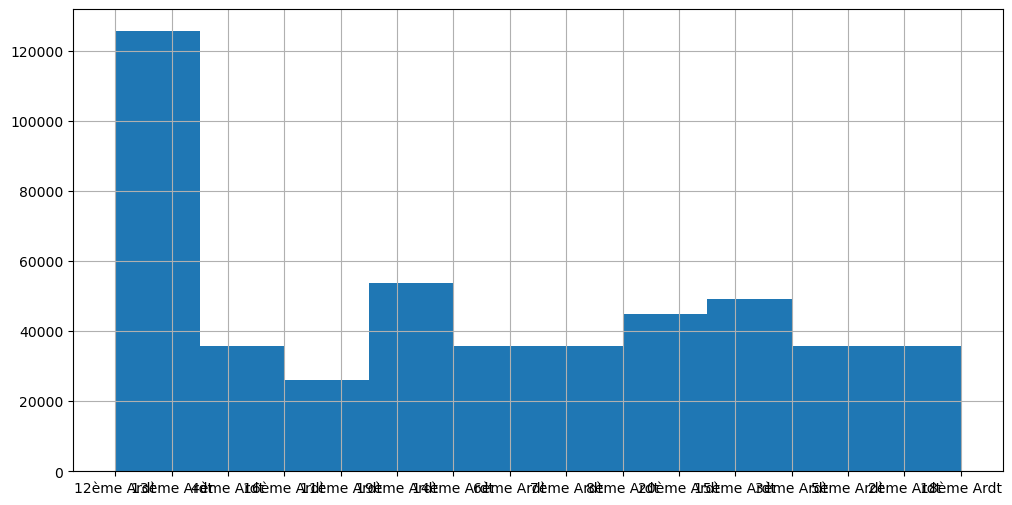

In [19]:
data_bike_arr['arrondissement'].hist(figsize=(12, 6)); # Let's have a look at feature we added

We notice that : 
* The arrondissements with the most bikes are the 11th, the 12th, the 13th, the 14th, the 19th and the 20th
* In the the 10th, there is no bikes, and much fewer than elswehere in the 7th, 8th, 9th 

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

# Adding the arrondissement after getting rid of extra data - name of the file : data_bike_arr_rid

In [20]:
data_bike_arr_rid = data_bike_rid.copy()

In [21]:
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoJSON file containing Paris arrondissements
arrondissements = gpd.read_file(Path("external_data") / "arrondissements.geojson")

# Ensure arrondissements GeoDataFrame has a compatible CRS
arrondissements = arrondissements.to_crs(epsg=4326)

# Assuming 'data' is your original dataset with latitude and longitude columns
data_bike_arr_rid['geometry'] = gpd.points_from_xy(data_bike_arr_rid['longitude'], data_bike_arr_rid['latitude'], crs="EPSG:4326")

# Convert the DataFrame to a GeoDataFrame
data_gdf = gpd.GeoDataFrame(data_bike_arr_rid, geometry='geometry')

# Perform the spatial join
result = gpd.sjoin(data_gdf, arrondissements, how="left", predicate="within")


# Access the relevant arrondissement column
data_bike_arr_rid['arrondissement'] = result[['l_ar']]  # Replace 'nom' with the arrondissement column name

data_bike_arr_rid.head()


,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,bike_count,log_bike_count,geometry,arrondissement
48321,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 02:00:00,2013-01-18,0.0,0.000000,POINT (2.37543 48.84603),12ème Ardt
48324,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 03:00:00,2013-01-18,1.0,0.693147,POINT (2.37543 48.84603),12ème Ardt
48327,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 04:00:00,2013-01-18,0.0,0.000000,POINT (2.37543 48.84603),12ème Ardt
48330,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 15:00:00,2013-01-18,4.0,1.609438,POINT (2.37543 48.84603),12ème Ardt
48333,48.846028,2.375429,28 boulevard Diderot E-O,28 boulevard Diderot,Y2H15027244,2020-09-01 18:00:00,2013-01-18,9.0,2.302585,POINT (2.37543 48.84603),12ème Ardt


In [22]:
data_bike_arr_rid= data_bike_arr_rid.drop(columns='geometry')

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44

# Adding the external meteorological data : data_bike_meteo

In [21]:
external_data = pd.read_csv((Path("data") / "external_data.csv"))

In [ ]:
external_data.head()